# Skin cancer Classification

## Importing all the packages

In [1]:
import tensorflow as tf
#Check GPU and CUDA Compatibility
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))
tf.config.list_physical_devices('GPU')

2.4.1
True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.densenet import DenseNet121
from keras.preprocessing.image import load_img,img_to_array,save_img,array_to_img
from sklearn.metrics import classification_report
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.utils import shuffle
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import re
import shutil
import string
import pycm
import glob
import itertools
from collections import defaultdict
import random
from tqdm.notebook import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
#from focal_loss import SparseCategoricalFocalLoss
import swifter
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots
import joypy
import lightgbm as lgb

## Data

## Reading the metadeta

In [3]:
df=pd.read_csv('dataverse_files/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
name_index=df['dx'].value_counts().index

df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

### Visualising the data

<IPython.core.display.Javascript object>


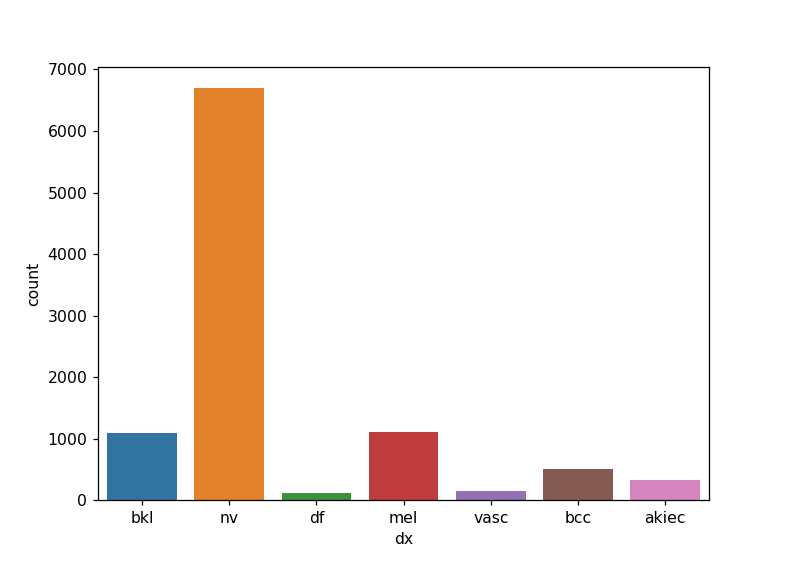

<AxesSubplot:xlabel='dx', ylabel='count'>

In [5]:
fig,ax=plt.subplots(figsize=(7,5))
sns.countplot(x=df['dx'],data=df,ax=ax)

<IPython.core.display.Javascript object>


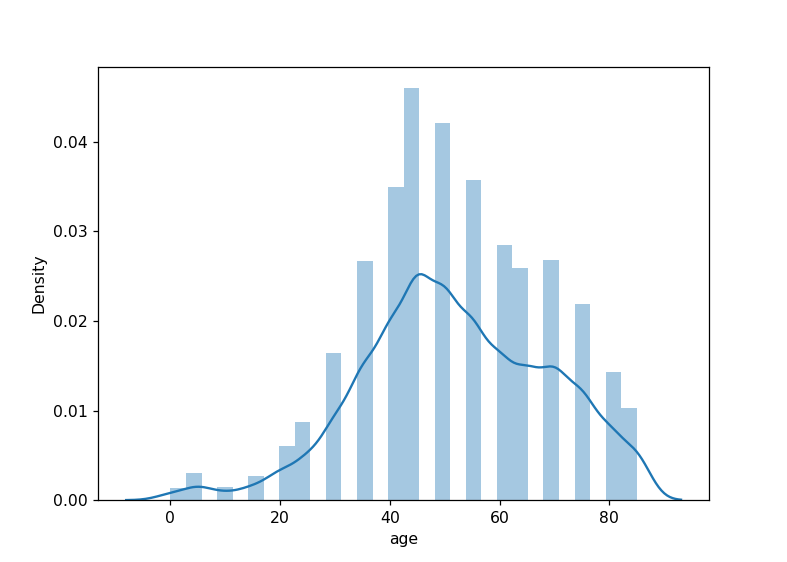

<AxesSubplot:xlabel='age', ylabel='Density'>

In [6]:
fig,ax=plt.subplots(figsize=(7,5))
sns.distplot(df['age'],ax=ax,bins=30)

## Spliting of data set into traning,testing and validation

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df['image_id'],
    df['dx'],
    test_size=0.1,
    random_state=0,
    stratify=df['dx']
)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=0,
    stratify=y_train
)

In [9]:
print(len(y_train))
y_train.value_counts()

8111


nv       5430
mel       902
bkl       890
bcc       417
akiec     264
vasc      115
df         93
Name: dx, dtype: int64

In [10]:
print(len(y_valid))
y_valid.value_counts()

902


nv       604
mel      100
bkl       99
bcc       46
akiec     30
vasc      13
df        10
Name: dx, dtype: int64

In [11]:
print(len(y_test))
y_test.value_counts()

1002


nv       671
mel      111
bkl      110
bcc       51
akiec     33
vasc      14
df        12
Name: dx, dtype: int64

## Separation of images into directories

In [12]:
dir_name=['train','validation','test']
parent_dir = 'dataverse_files'

for name in dir_name:
    path=os.path.join(parent_dir,name)
    os.mkdir(path)
    parent_dir1=parent_dir+'/'+name
    for name1 in name_index:
        path1=os.path.join(parent_dir1,name1)
        os.mkdir(path1)

In [35]:
train_images = pd.concat([X_train,y_train], axis=1).reset_index(drop=True)
valid_images = pd.concat([X_valid,y_valid], axis=1).reset_index(drop=True)
test_images = pd.concat([X_test,y_test], axis=1).reset_index(drop=True)

### Loading in dirs 

In [36]:
def make_dir(df,name):
    for i in tqdm(range(0,len(df))):
        path="dataverse_files/"
        shutil.copy(path+'HAM10000_images/'+df['image_id'][i]+'.jpg',path+name+'/'+df['dx'][i])

In [37]:
make_dir(train_images,'train')

In [88]:
make_dir(valid_images,'validation')

In [89]:
make_dir(test_images,'test')

## Investigating Image Properties 

In [21]:
# load the image
img = load_img(
    'dataverse_files/train/nv/ISIC_0024307.jpg')
# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)
# show the image
img.show()

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(600, 450)


<IPython.core.display.Javascript object>


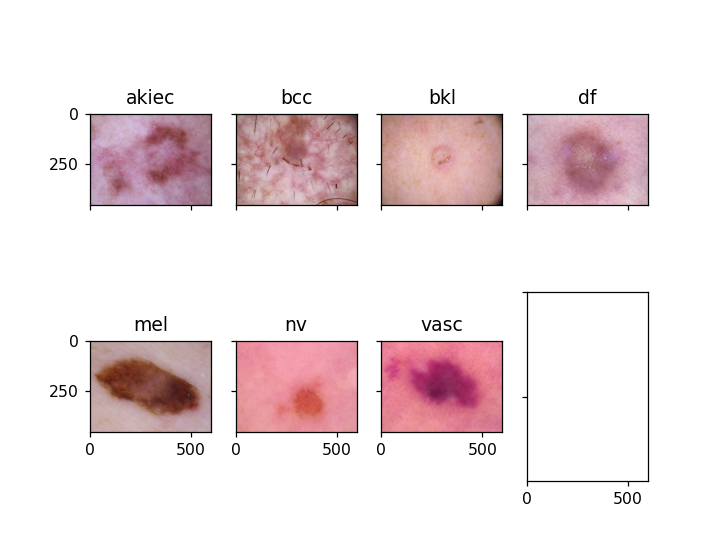

In [71]:
img = df.groupby('dx').sample(1)
fig, ax = plt.subplots(2,4, sharex=True, sharey=True)
i = j = -1
for imgs, dx in zip(img['image_id'], img['dx']):
    image = plt.imread("dataverse_files/HAM10000_images/" + imgs+'.jpg')
    
    if i == -1:
        i = j = 0
    elif j == 3:
        i += 1
        j = 0
    else:
        j +=1
    ax[i, j].imshow(image)
    ax[i, j].set_title(dx)
    

In [22]:
img_array = img_to_array(img)
print(img_array.shape)
print(img_array.dtype)

(450, 600, 3)
float32


In [23]:
img_array

array([[[213., 123., 135.],
        [215., 122., 133.],
        [219., 123., 134.],
        ...,
        [224., 142., 156.],
        [229., 147., 159.],
        [226., 144., 156.]],

       [[213., 123., 133.],
        [216., 125., 134.],
        [215., 124., 133.],
        ...,
        [226., 144., 156.],
        [227., 145., 157.],
        [228., 144., 157.]],

       [[211., 121., 133.],
        [215., 122., 133.],
        [214., 121., 132.],
        ...,
        [227., 143., 158.],
        [226., 142., 157.],
        [226., 142., 157.]],

       ...,

       [[199., 121., 117.],
        [200., 127., 118.],
        [200., 125., 120.],
        ...,
        [206., 135., 141.],
        [208., 135., 142.],
        [208., 137., 143.]],

       [[202., 121., 120.],
        [201., 121., 120.],
        [203., 123., 122.],
        ...,
        [205., 134., 140.],
        [208., 138., 140.],
        [209., 143., 144.]],

       [[199., 122., 116.],
        [197., 122., 117.],
        [203., 1

# Learning - Base Model

## Setting DataGenerators 

In [24]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('dataverse_files/train/',
                                                 target_size = (300,400),
                                                 batch_size = 32,
                                                 color_mode = 'rgb',
                                                 class_mode = 'categorical')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
validating_set = valid_datagen.flow_from_directory('dataverse_files/validation/',
                                                 target_size = (300,400),
                                                 batch_size = 32,
                                                 color_mode = 'rgb',
                                                 class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('dataverse_files/test',
                                            target_size = (300,400),
                                            batch_size = 1,
                                            color_mode = 'rgb',
                                            class_mode = 'categorical')

Found 8111 images belonging to 7 classes.
Found 902 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


### CNN model 1

In [26]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[300, 400, 3]),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=3),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=500, activation='relu'),
    tf.keras.layers.Dense(units=7, activation='softmax')
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 398, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 296, 396, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 132, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 130, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 128, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 42, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 40, 32)        9

In [27]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 398, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 296, 396, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 132, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 130, 32)       9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 128, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 42, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 40, 32)        9

In [30]:
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=4,
                                      restore_best_weights=True)
filepath_acc = 'best_model_acc.hdf5'
checkpoint_acc = ModelCheckpoint(filepath_acc,
                                 monitor='val_categorical_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')
filepath_loss = 'best_model_loss.hdf5'
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min')

In [32]:
history = cnn.fit(x=training_set,
                  validation_data=validating_set,
                  epochs=25,
                  callbacks=[es, checkpoint_loss, checkpoint_acc])

Epoch 1/25
254/254 [==============================] - 294s 1s/step - loss: 1.1199 - categorical_accuracy: 0.6527 - val_loss: 0.9266 - val_categorical_accuracy: 0.6696

Epoch 00001: val_loss improved from inf to 0.92664, saving model to best_model_loss.hdf5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.66962, saving model to best_model_acc.hdf5
Epoch 2/25
254/254 [==============================] - 242s 953ms/step - loss: 0.9718 - categorical_accuracy: 0.6706 - val_loss: 0.9055 - val_categorical_accuracy: 0.6896

Epoch 00002: val_loss improved from 0.92664 to 0.90554, saving model to best_model_loss.hdf5

Epoch 00002: val_categorical_accuracy improved from 0.66962 to 0.68958, saving model to best_model_acc.hdf5
Epoch 3/25
254/254 [==============================] - 246s 968ms/step - loss: 0.9075 - categorical_accuracy: 0.6857 - val_loss: 0.9234 - val_categorical_accuracy: 0.6785

Epoch 00003: val_loss did not improve from 0.90554

Epoch 00003: val_categorical_accuracy did

In [33]:
cnn_loss = load_model('./best_model_loss.hdf5')
cnn_acc = load_model('./best_model_acc.hdf5')

## Evaluation 

In [34]:
[loss, cat_acc] = cnn_loss.evaluate(test_set)
print(loss, cat_acc*100)

1002/1002 [==============================] - 18s 18ms/step - loss: 0.7410 - categorical_accuracy: 0.7176
0.7410116791725159 71.75648808479309


In [35]:
[loss, cat_acc] = cnn_acc.evaluate(test_set)
print(loss, cat_acc*100)

1002/1002 [==============================] - 13s 13ms/step - loss: 0.7100 - categorical_accuracy: 0.7375
0.7099745869636536 73.7524926662445


<IPython.core.display.Javascript object>


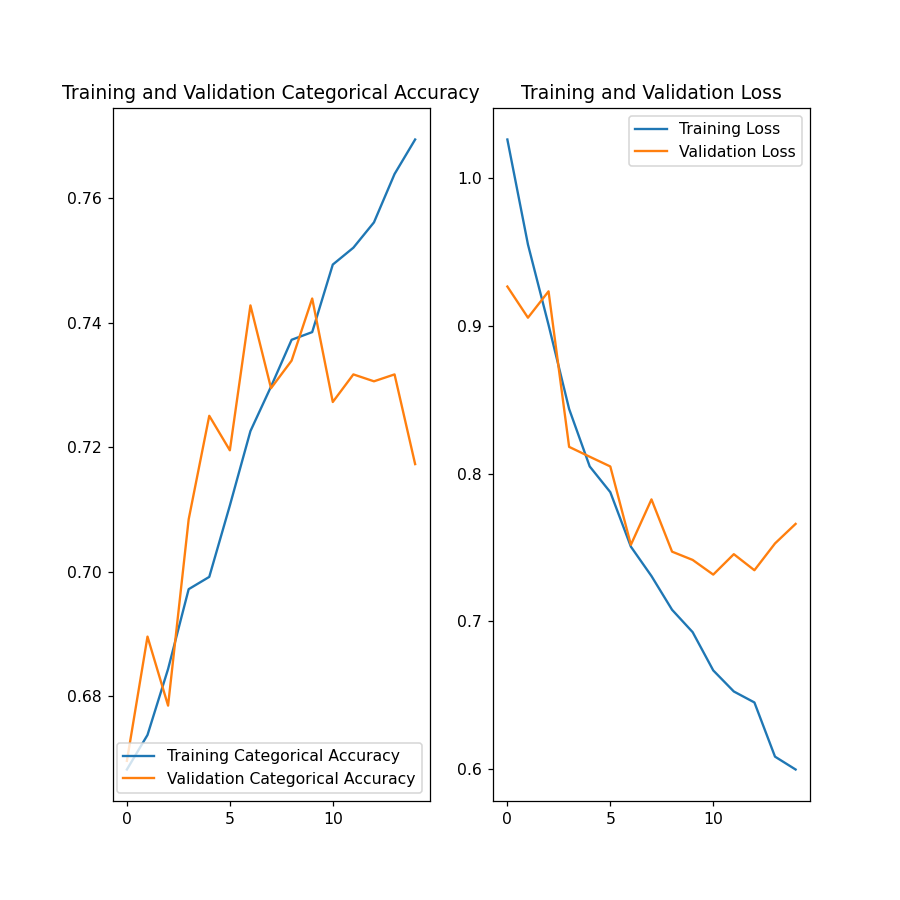

In [36]:
cat_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cat_acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Categorical Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Report 

In [37]:
y_pred_loss = cnn_loss.predict(test_set)
y_pred_acc = cnn_acc.predict(test_set)

In [38]:
#Extracting Image Data and Target Labels of test_set as nparray
X_test = np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y_test = np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print("Test - Images Shape: ", X_test.shape, '\n')
print("Test - Labels Shape: ", y_test.shape)

Test - Images Shape:  (1002, 300, 400, 3) 

Test - Labels Shape:  (1002, 7)


In [39]:
from sklearn.metrics import classification_report
print("Min-Loss CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_loss.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel'])
print(report)

Min-Loss CNN: 

              precision    recall  f1-score   support

       akiec       0.05      0.03      0.04        33
         bcc       0.00      0.00      0.00        51
         bkl       0.05      0.02      0.03       110
          df       0.00      0.00      0.00        12
          nv       0.18      0.05      0.07       111
        vasc       0.66      0.86      0.75       671
         mel       0.00      0.00      0.00        14

    accuracy                           0.58      1002
   macro avg       0.14      0.14      0.13      1002
weighted avg       0.47      0.58      0.51      1002



C:\Users\suraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
from sklearn.metrics import classification_report
print("Max-Acc CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_acc.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel'])
print(report)

Max-Acc CNN: 

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.03      0.02      0.02        51
         bkl       0.19      0.13      0.15       110
          df       0.00      0.00      0.00        12
          nv       0.05      0.03      0.04       111
        vasc       0.68      0.82      0.74       671
         mel       0.08      0.07      0.08        14

    accuracy                           0.57      1002
   macro avg       0.15      0.15      0.15      1002
weighted avg       0.48      0.57      0.52      1002



In [42]:
confusion_mtx = confusion_matrix(y_test.argmax(axis=1), y_pred_loss.argmax(axis=1))
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
confusion_mtx

array([[  1,   1,   1,   0,   0,  29,   1],
       [  0,   0,   2,   0,   0,  47,   2],
       [  3,   6,   2,   0,   1,  98,   0],
       [  0,   0,   0,   0,   2,   9,   1],
       [  3,   4,   4,   0,   5,  95,   0],
       [ 13,  25,  28,   0,  20, 578,   7],
       [  0,   0,   0,   0,   0,  14,   0]], dtype=int64)

# Learning - Augmenting Data for Imbalanced Classes 

## Data Augmentation 

In [149]:
#make the directory
dir_name=['train_aug']
parent_dir = 'dataverse_files'

for name in dir_name:
    path=os.path.join(parent_dir,name)
    os.mkdir(path)
    parent_dir1=parent_dir+'/'+name
    for name1 in name_index:
        path1=os.path.join(parent_dir1,name1)
        os.mkdir(path1)

In [151]:
def make_dir(df,name):
    # df :name of the pandas dataframe
    # name: dir name
    for i in tqdm(range(0,len(df))):
        path="dataverse_files/"
        if df['dx'][i] not in ['df', 'bcc', 'vasc', 'akiec']:
            shutil.copy(path+'HAM10000_images/'+df['image_id'][i]+'.jpg',path+name+'/'+df['dx'][i])

In [152]:
make_dir(train_images,'train_aug')

In [164]:
def augment(dirs,save_dir ,n):
    # dirs: directory of the class for which data needs to be augmented
    # save_dir : the directory where the classes are to be saved
    # n: times the data needs to be oversampled

    datagen = ImageDataGenerator()
    dirs1 = dirs+'*'
    for i in tqdm(range(n)):
        for imgs in glob.glob(dirs1):
            img = load_img(imgs)
            img = img_to_array(img)
            z = np.random.uniform(0.3,0.65)
            s = np.random.uniform(0, 45)
            c = np.random.uniform(0, 30)
            generate = datagen.apply_transform(x=img,
                                               transform_parameters={
                                                   'zx':
                                                   z,
                                                   'zy':
                                                   z,
                                                   'theta':
                                                   s,
                                                   'flip_horizontal':
                                                   random.choice([0, 1]),
                                                   'flip_vertical':
                                                   random.choice([0, 1]),
                                                   'channel_shift_intensity': c
                                               })
            new_save_dir = save_dir + imgs[-16:-4] + '_aug' + str(i) + '.jpg'
            save_img(new_save_dir, generate)

In [165]:
np.random.uniform(0, 20)

4.883124002585541

In [166]:
augment('dataverse_files/train/df/', 'dataverse_files/train_aug/df/', 11)
augment('dataverse_files/train/vasc/', 'dataverse_files/train_aug/vasc/',  10)
augment('dataverse_files/train/akiec/', 'dataverse_files/train_aug/akiec/',5)
augment('dataverse_files/train/bcc/', 'dataverse_files/train_aug/bcc/',2)

## Setting DataGenerators /

In [102]:
train_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=45, zoom_range=[0.6,0.7])
training_set = train_datagen.flow_from_directory(
    'dataverse_files/train_aug/',
    target_size=(224, 224),
    batch_size=8,
    color_mode='rgb',
    class_mode='categorical',
    subset='training')

valid_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=45, zoom_range=[0.6,0.7])
validating_set = valid_datagen.flow_from_directory(
    'dataverse_files/validation/',
    target_size=(224, 224),
    batch_size=8,
    color_mode='rgb',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_set = test_datagen.flow_from_directory(
    'dataverse_files/test/',
    target_size=(224, 224),
    batch_size=1,
    color_mode='rgb',
    class_mode='categorical')

Found 11549 images belonging to 7 classes.
Found 902 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


In [108]:
cnn2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[224, 224, 3]),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=3),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=500, activation='relu'),
    tf.keras.layers.Dense(units=7, activation='softmax')
])

cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 71, 71, 32)        9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 69, 69, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 21, 21, 32)       

In [109]:
cnn2.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=4,
                                      restore_best_weights=True)
filepath_acc = 'best_model2_acc.hdf5'
checkpoint_acc = ModelCheckpoint(filepath_acc,
                                 monitor='val_categorical_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')
filepath_loss = 'best_model2_loss.hdf5'
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min')

In [110]:
history2 = cnn2.fit(x=training_set,
                  validation_data=validating_set,
                  epochs=25,
                  callbacks=[es, checkpoint_loss, checkpoint_acc])

Epoch 1/25
1444/1444 [==============================] - 264s 182ms/step - loss: 1.5728 - categorical_accuracy: 0.4785 - val_loss: 1.0736 - val_categorical_accuracy: 0.6508

Epoch 00001: val_loss improved from inf to 1.07364, saving model to best_model2_loss.hdf5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.65078, saving model to best_model2_acc.hdf5
Epoch 2/25
1444/1444 [==============================] - 202s 140ms/step - loss: 1.1957 - categorical_accuracy: 0.5870 - val_loss: 0.8784 - val_categorical_accuracy: 0.7029

Epoch 00002: val_loss improved from 1.07364 to 0.87843, saving model to best_model2_loss.hdf5

Epoch 00002: val_categorical_accuracy improved from 0.65078 to 0.70288, saving model to best_model2_acc.hdf5
Epoch 3/25
1444/1444 [==============================] - 199s 138ms/step - loss: 0.9935 - categorical_accuracy: 0.6458 - val_loss: 0.9577 - val_categorical_accuracy: 0.6896

Epoch 00003: val_loss did not improve from 0.87843

Epoch 00003: val_categorical

In [111]:
cnn_loss2 = load_model('./best_model2_loss.hdf5')
cnn_acc = load_model('./best_model2_acc.hdf5')

### Evalution

In [112]:
[loss, cat_acc] = cnn_loss2.evaluate(test_set)
print(loss, cat_acc*100)

1002/1002 [==============================] - 21s 20ms/step - loss: 0.8996 - categorical_accuracy: 0.6926
0.8995786905288696 69.26147937774658


In [113]:
[loss, cat_acc] = cnn_acc.evaluate(test_set)
print(loss, cat_acc*100)

1002/1002 [==============================] - 15s 15ms/step - loss: 0.8996 - categorical_accuracy: 0.6926
0.8995788097381592 69.26147937774658


In [114]:
y_pred_loss = cnn_loss2.predict(test_set)
y_pred_acc = cnn_acc.predict(test_set)

In [115]:
#Extracting Image Data and Target Labels of test_set as nparray
X_test = np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y_test = np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print("Test - Images Shape: ", X_test.shape, '\n')
print("Test - Labels Shape: ", y_test.shape)

Test - Images Shape:  (1002, 224, 224, 3) 

Test - Labels Shape:  (1002, 7)


In [116]:
from sklearn.metrics import classification_report
print("Min-Loss CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_loss.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel'])
print(report)

Min-Loss CNN: 

              precision    recall  f1-score   support

       akiec       0.05      0.12      0.07        33
         bcc       0.00      0.00      0.00        51
         bkl       0.11      0.07      0.09       110
          df       0.00      0.00      0.00        12
          nv       0.06      0.02      0.03       111
        vasc       0.66      0.79      0.72       671
         mel       0.00      0.00      0.00        14

    accuracy                           0.54      1002
   macro avg       0.13      0.14      0.13      1002
weighted avg       0.46      0.54      0.50      1002



In [117]:
from sklearn.metrics import classification_report
print("Max-Acc CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_acc.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel'])
print(report)

Max-Acc CNN: 

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.00      0.00      0.00        51
         bkl       0.12      0.08      0.10       110
          df       0.00      0.00      0.00        12
          nv       0.09      0.03      0.04       111
        vasc       0.66      0.79      0.72       671
         mel       0.07      0.07      0.07        14

    accuracy                           0.54      1002
   macro avg       0.14      0.14      0.13      1002
weighted avg       0.47      0.54      0.50      1002



In [118]:
confusion_mtx = confusion_matrix(y_test.argmax(axis=1), y_pred_loss.argmax(axis=1))
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
confusion_mtx

array([[  4,   0,   2,   0,   3,  24,   0],
       [  2,   0,   5,   0,   1,  42,   1],
       [  5,   0,   8,   0,   4,  90,   3],
       [  1,   0,   0,   0,   1,  10,   0],
       [  7,   0,   6,   0,   2,  94,   2],
       [ 57,   1,  50,   1,  21, 532,   9],
       [  1,   0,   1,   0,   1,  11,   0]], dtype=int64)

## Setting DenseNet-121 Architecture

In [18]:
from tensorflow.keras.applications.densenet import DenseNet121

In [19]:
densenet_121 = DenseNet121(include_top=False,input_shape=[224,224,3])
densenet_121.trainable=True
densenet_121.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [20]:
output_layer = densenet_121.get_layer('relu')
print('output layer shape={}'.format(output_layer.output_shape))
out=output_layer.output

output layer shape=(None, 7, 7, 1024)


## Training -  Using DenseNet-121 Architecture

In [170]:
x = tf.keras.layers.MaxPooling2D(3,3)(out)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

output = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.models.Model(densenet_121.input,output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [171]:
datagen=ImageDataGenerator(rescale=1./255.,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen=ImageDataGenerator(rescale = 1./255)
train_path='dataverse_files/train/'
valid_path='dataverse_files/validation/'
test_path='dataverse_files/test/'

X_train=datagen.flow_from_directory(train_path,
                                    target_size=(300,400),
                                    class_mode='categorical',
                                    batch_size=16,
                                    color_mode='rgb')
X_valid=test_datagen.flow_from_directory(valid_path,
                                         target_size=(300,400),
                                         class_mode='categorical',
                                         batch_size=16,
                                         color_mode='rgb')
X_test=test_datagen.flow_from_directory(test_path,
                                        target_size=(300,400),
                                        class_mode='categorical',
                                        color_mode='rgb')


Found 8111 images belonging to 7 classes.
Found 902 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


In [172]:
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=7,
                                      restore_best_weights=True)

filepath_acc = 'best_model_acc_3.hdf5'
checkpoint_acc = ModelCheckpoint(filepath_acc,
                                 monitor='val_categorical_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')

filepath_loss = 'best_model_loss_3.hdf5'
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min')

In [174]:
history = model.fit(x=training_set,
                  validation_data=validating_set,
                  epochs=50,
                  callbacks=[es, checkpoint_loss, checkpoint_acc])

Epoch 1/50
1444/1444 [==============================] - 341s 236ms/step - loss: 1.1693 - categorical_accuracy: 0.5906 - val_loss: 0.8157 - val_categorical_accuracy: 0.6918

Epoch 00001: val_loss improved from inf to 0.81568, saving model to best_model_loss_3.hdf5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.69180, saving model to best_model_acc_3.hdf5
Epoch 2/50
1444/1444 [==============================] - 323s 223ms/step - loss: 0.9550 - categorical_accuracy: 0.6402 - val_loss: 0.9246 - val_categorical_accuracy: 0.6763

Epoch 00002: val_loss did not improve from 0.81568

Epoch 00002: val_categorical_accuracy did not improve from 0.69180
Epoch 3/50
1444/1444 [==============================] - 315s 218ms/step - loss: 0.8550 - categorical_accuracy: 0.6700 - val_loss: 1.4482 - val_categorical_accuracy: 0.6696

Epoch 00003: val_loss did not improve from 0.81568

Epoch 00003: val_categorical_accuracy did not improve from 0.69180
Epoch 4/50
1444/1444 [======================

In [175]:
model_loss = load_model('./best_model_loss_3.hdf5')
model_acc = load_model('./best_model_acc_3.hdf5')

## Evaluation 

In [176]:
[loss, cat_acc] = model_loss.evaluate(test_set)
print(loss, cat_acc*100)

1002/1002 [==============================] - 36s 34ms/step - loss: 0.9801 - categorical_accuracy: 0.6886
0.9800792932510376 68.8622772693634


In [177]:
[loss, cat_acc] = model_acc.evaluate(test_set)
print(loss, cat_acc*100)

1002/1002 [==============================] - 35s 29ms/step - loss: 0.9801 - categorical_accuracy: 0.6886
0.9800799489021301 68.8622772693634


### Graphs 

<IPython.core.display.Javascript object>


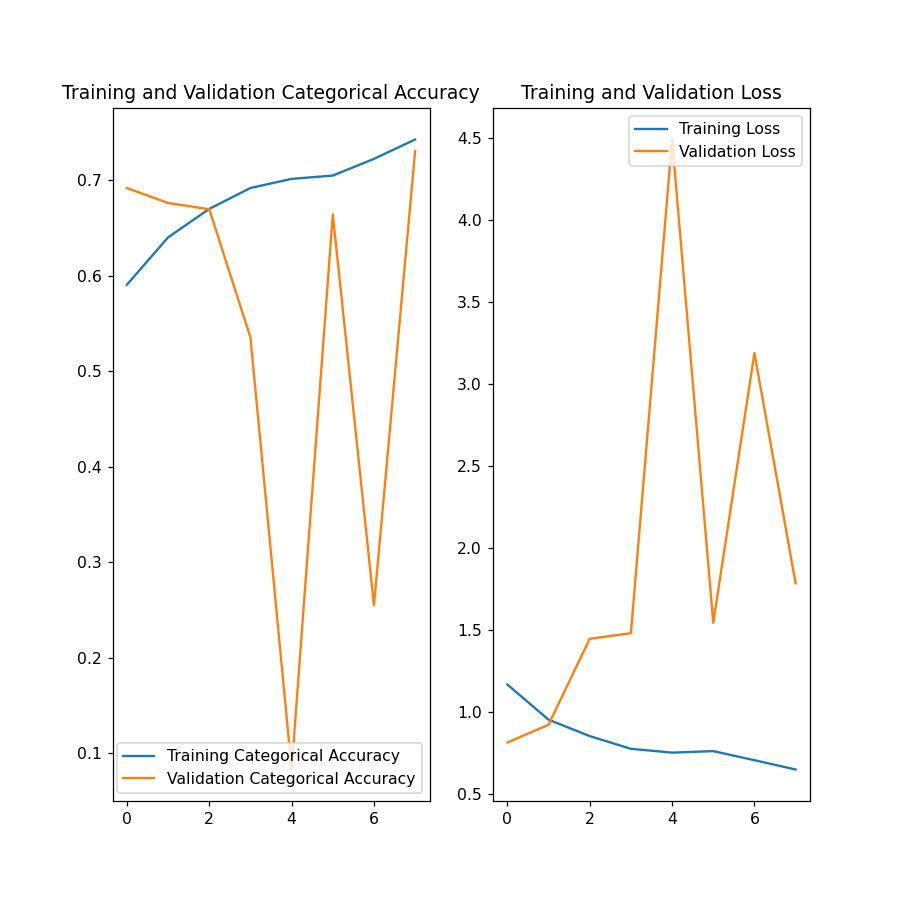

In [178]:
cat_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['val_loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cat_acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Categorical Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Report 

In [179]:
y_pred_loss = model_loss.predict(test_set)
y_pred_acc = model_acc.predict(test_set)

In [180]:
X_test = np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y_test = np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print("Test - Images Shape: ", X_test.shape, '\n')
print("Test - Labels Shape: ", y_test.shape)

Test - Images Shape:  (1002, 224, 224, 3) 

Test - Labels Shape:  (1002, 7)


In [181]:
from sklearn.metrics import classification_report
print("Min-Loss CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_loss.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
print(report)

Min-Loss CNN: 

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.00      0.00      0.00        51
         bkl       0.06      0.03      0.04       110
          df       0.00      0.00      0.00        12
         mel       0.00      0.00      0.00       111
          nv       0.67      0.93      0.78       671
        vasc       0.00      0.00      0.00        14

    accuracy                           0.63      1002
   macro avg       0.10      0.14      0.12      1002
weighted avg       0.46      0.63      0.53      1002



In [182]:
from sklearn.metrics import classification_report
print("Max-Acc CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_acc.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
print(report)

Max-Acc CNN: 

              precision    recall  f1-score   support

       akiec       0.25      0.03      0.05        33
         bcc       0.00      0.00      0.00        51
         bkl       0.08      0.04      0.05       110
          df       0.00      0.00      0.00        12
         mel       0.00      0.00      0.00       111
          nv       0.67      0.93      0.78       671
        vasc       0.00      0.00      0.00        14

    accuracy                           0.63      1002
   macro avg       0.14      0.14      0.13      1002
weighted avg       0.47      0.63      0.53      1002



In [183]:
confusion_mtx = confusion_matrix(y_test.argmax(axis=1), y_pred_loss.argmax(axis=1))
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
confusion_mtx

array([[  0,   0,   3,   0,   0,  30,   0],
       [  0,   0,   2,   0,   0,  48,   1],
       [  1,   0,   3,   0,   0, 105,   1],
       [  0,   0,   0,   0,   0,  12,   0],
       [  0,   1,  10,   0,   0,  99,   1],
       [  3,   1,  33,   0,   0, 625,   9],
       [  0,   0,   2,   0,   0,  12,   0]], dtype=int64)

## DenseNet with augumented image

In [184]:
datagen=ImageDataGenerator(rescale=1./255.,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen=ImageDataGenerator(rescale = 1./255)
train_path='dataverse_files/train_aug/'
valid_path='dataverse_files/validation/'
test_path='dataverse_files/test/'

X_train=datagen.flow_from_directory(train_path,
                                    target_size=(300,400),
                                    class_mode='categorical',
                                    batch_size=16,
                                    color_mode='rgb')
X_valid=test_datagen.flow_from_directory(valid_path,
                                         target_size=(300,400),
                                         class_mode='categorical',
                                         batch_size=16,
                                         color_mode='rgb')
X_test=test_datagen.flow_from_directory(test_path,
                                        target_size=(300,400),
                                        class_mode='categorical',
                                        color_mode='rgb')


Found 11556 images belonging to 7 classes.
Found 902 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


In [185]:
x = tf.keras.layers.MaxPooling2D(3,3)(out)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

output = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.models.Model(densenet_121.input,output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv5_block8_2_conv (Conv2D)    (None, 7, 7, 32)     36864       conv5_block8_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block8_concat (Concatenat (None, 7, 7, 768)    0           conv5_block7_concat[0][0]        
                                                                 conv5_block8_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block9_0_bn (BatchNormali (None, 7, 7, 768)    3072        conv5_block8_concat[0][0]        
__________________________________________________________________________________________________
conv5_block9_0_relu (Activation (None, 7, 7, 768)    0           conv5_block9_0_bn[0][0]          
__________________________________________________________________________________________________
conv5_bloc

In [197]:
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',
                                      mode='min',
                                      verbose=1,
                                      patience=7,
                                      restore_best_weights=True)

filepath_acc = 'best_model_acc_4.hdf5'
checkpoint_acc = ModelCheckpoint(filepath_acc,
                                 monitor='val_categorical_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')

filepath_loss = 'best_model_loss_4.hdf5'
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min')

In [198]:
history = model.fit(x=training_set,
                  validation_data=validating_set,
                  epochs=50,
                  callbacks=[es, checkpoint_loss, checkpoint_acc])

Epoch 1/50
1444/1444 [==============================] - 349s 233ms/step - loss: 0.7012 - categorical_accuracy: 0.7234 - val_loss: 4.0121 - val_categorical_accuracy: 0.0765

Epoch 00001: val_loss improved from inf to 4.01209, saving model to best_model_loss_4.hdf5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.07650, saving model to best_model_acc_4.hdf5
Epoch 2/50
1444/1444 [==============================] - 391s 270ms/step - loss: 0.6886 - categorical_accuracy: 0.7319 - val_loss: 1.1049 - val_categorical_accuracy: 0.6208

Epoch 00002: val_loss improved from 4.01209 to 1.10492, saving model to best_model_loss_4.hdf5

Epoch 00002: val_categorical_accuracy improved from 0.07650 to 0.62084, saving model to best_model_acc_4.hdf5
Epoch 3/50
1444/1444 [==============================] - 395s 273ms/step - loss: 0.6591 - categorical_accuracy: 0.7496 - val_loss: 0.9718 - val_categorical_accuracy: 0.7151

Epoch 00003: val_loss improved from 1.10492 to 0.97185, saving model to best

***Loss plateaus out quickly at val_loss = 0.97 for another epochs: 2-9 indicating no sign of improvement***

In [199]:
model_loss = load_model('./best_model_loss_4.hdf5')
model_acc = load_model('./best_model_acc_4.hdf5')

### Evaluation

In [200]:
[loss, cat_acc] = model_loss.evaluate(test_set)
print(loss, cat_acc*100)

1002/1002 [==============================] - 32s 30ms/step - loss: 1.1310 - categorical_accuracy: 0.7096
1.1310317516326904 70.95808386802673


In [201]:
[loss, cat_acc] = model_acc.evaluate(test_set)
print(loss, cat_acc*100)

1002/1002 [==============================] - 33s 30ms/step - loss: 1.1310 - categorical_accuracy: 0.7096
1.131029486656189 70.95808386802673


### Graph

In [202]:
cat_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['val_loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cat_acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Categorical Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<IPython.core.display.Javascript object>

### Report

In [203]:
y_pred_loss = model_loss.predict(test_set)
y_pred_acc = model_acc.predict(test_set)

In [204]:
X_test = np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y_test = np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print("Test - Images Shape: ", X_test.shape, '\n')
print("Test - Labels Shape: ", y_test.shape)

Test - Images Shape:  (1002, 224, 224, 3) 

Test - Labels Shape:  (1002, 7)


In [205]:
from sklearn.metrics import classification_report
print("Min-Loss CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_loss.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
print(report)

Min-Loss CNN: 

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.00      0.00      0.00        51
         bkl       0.08      0.07      0.08       110
          df       0.00      0.00      0.00        12
         mel       0.00      0.00      0.00       111
          nv       0.68      0.88      0.77       671
        vasc       0.00      0.00      0.00        14

    accuracy                           0.59      1002
   macro avg       0.11      0.14      0.12      1002
weighted avg       0.46      0.59      0.52      1002



In [206]:

print("Max-Acc CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_acc.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
print(report)

Max-Acc CNN: 

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.00      0.00      0.00        51
         bkl       0.06      0.05      0.06       110
          df       0.00      0.00      0.00        12
         mel       0.12      0.02      0.03       111
          nv       0.66      0.85      0.74       671
        vasc       0.00      0.00      0.00        14

    accuracy                           0.58      1002
   macro avg       0.12      0.13      0.12      1002
weighted avg       0.46      0.58      0.51      1002



In [207]:
confusion_mtx = confusion_matrix(y_test.argmax(axis=1), y_pred_loss.argmax(axis=1))
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
confusion_mtx

array([[  0,   1,   6,   0,   0,  26,   0],
       [  0,   0,   6,   0,   2,  42,   1],
       [  0,   2,   8,   0,   5,  94,   1],
       [  0,   0,   0,   0,   0,  12,   0],
       [  0,   5,  14,   0,   0,  90,   2],
       [  0,   9,  61,   1,  10, 588,   2],
       [  0,   0,   2,   0,   0,  12,   0]], dtype=int64)

## Using Learning Rate Annealing with non augumented image

In [21]:
x = tf.keras.layers.MaxPooling2D(3,3)(out)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

output = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.models.Model(densenet_121.input,output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [22]:
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])

filepath_acc = 'best_model_acc_lra.hdf5'
checkpoint_acc = ModelCheckpoint(filepath_acc,
                                 monitor='val_categorical_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')

filepath_loss = 'best_model_loss_lra.hdf5'
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [25]:
datagen=ImageDataGenerator(rescale=1./255.,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen=ImageDataGenerator(rescale = 1./255)
train_path='dataverse_files/train/'
valid_path='dataverse_files/validation/'
test_path='dataverse_files/test/'

training_set=datagen.flow_from_directory(train_path,
                                    target_size=(224,224),
                                    class_mode='categorical',
                                    batch_size=16,
                                    color_mode='rgb')
validating_set=test_datagen.flow_from_directory(valid_path,
                                         target_size=(224,224),
                                         class_mode='categorical',
                                         batch_size=16,
                                         color_mode='rgb')
test_set=test_datagen.flow_from_directory(test_path,
                                        target_size=(224,224),
                                        class_mode='categorical',
                                        color_mode='rgb')


Found 8111 images belonging to 7 classes.
Found 902 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


In [26]:
history = model.fit(x=training_set,
                  validation_data=validating_set,
                  epochs= 50,
                  callbacks=[learning_rate_reduction, checkpoint_loss, checkpoint_acc])

Epoch 1/50
507/507 [==============================] - 203s 390ms/step - loss: 1.3607 - categorical_accuracy: 0.6566 - val_loss: 0.8765 - val_categorical_accuracy: 0.6641

Epoch 00001: val_loss improved from inf to 0.87649, saving model to best_model_loss_lra.hdf5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.66408, saving model to best_model_acc_lra.hdf5
Epoch 2/50
507/507 [==============================] - 141s 278ms/step - loss: 0.8589 - categorical_accuracy: 0.6889 - val_loss: 0.7755 - val_categorical_accuracy: 0.7262

Epoch 00002: val_loss improved from 0.87649 to 0.77547, saving model to best_model_loss_lra.hdf5

Epoch 00002: val_categorical_accuracy improved from 0.66408 to 0.72616, saving model to best_model_acc_lra.hdf5
Epoch 3/50
507/507 [==============================] - 137s 270ms/step - loss: 0.8002 - categorical_accuracy: 0.7071 - val_loss: 0.7259 - val_categorical_accuracy: 0.7384

Epoch 00003: val_loss improved from 0.77547 to 0.72588, saving model to be

Epoch 26/50
507/507 [==============================] - 138s 273ms/step - loss: 0.3020 - categorical_accuracy: 0.8874 - val_loss: 0.7112 - val_categorical_accuracy: 0.7982

Epoch 00026: val_loss did not improve from 0.53051

Epoch 00026: val_categorical_accuracy did not improve from 0.83592
Epoch 27/50
507/507 [==============================] - 138s 273ms/step - loss: 0.2809 - categorical_accuracy: 0.8967 - val_loss: 0.7977 - val_categorical_accuracy: 0.7672

Epoch 00027: val_loss did not improve from 0.53051

Epoch 00027: val_categorical_accuracy did not improve from 0.83592
Epoch 28/50
507/507 [==============================] - 138s 272ms/step - loss: 0.2829 - categorical_accuracy: 0.8940 - val_loss: 0.5839 - val_categorical_accuracy: 0.8204

Epoch 00028: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00028: val_loss did not improve from 0.53051

Epoch 00028: val_categorical_accuracy did not improve from 0.83592
Epoch 29/50
507/507 [==========================

KeyboardInterrupt: 

In [27]:
model_loss = load_model('./best_model_loss_lra.hdf5')
model_acc = load_model('./best_model_acc_lra.hdf5')

## Evaluation 

In [28]:
[loss, cat_acc] = model_loss.evaluate(test_set)
print(loss, cat_acc*100)

32/32 [==============================] - 20s 491ms/step - loss: 0.5591 - categorical_accuracy: 0.8134
0.5590558648109436 81.33732676506042


In [29]:
[loss, cat_acc] = model_acc.evaluate(test_set)
print(loss, cat_acc*100)

32/32 [==============================] - 10s 259ms/step - loss: 0.5330 - categorical_accuracy: 0.8403
0.533027172088623 84.03193354606628


### Report

In [31]:
y_pred_loss = model_loss.predict(test_set)
y_pred_acc = model_acc.predict(test_set)

In [32]:
X_test = np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y_test = np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print("Test - Images Shape: ", X_test.shape, '\n')
print("Test - Labels Shape: ", y_test.shape)

Test - Images Shape:  (1002, 224, 224, 3) 

Test - Labels Shape:  (1002, 7)


In [35]:

print("Min-Loss CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_loss.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
print(report)

Min-Loss CNN: 

              precision    recall  f1-score   support

       akiec       0.03      0.03      0.03        33
         bcc       0.05      0.04      0.04        51
         bkl       0.08      0.07      0.07       110
          df       0.00      0.00      0.00        12
         mel       0.15      0.09      0.11       111
          nv       0.67      0.73      0.70       671
        vasc       0.06      0.07      0.06        14

    accuracy                           0.51      1002
   macro avg       0.15      0.15      0.15      1002
weighted avg       0.48      0.51      0.49      1002



In [36]:
from sklearn.metrics import classification_report
print("Max-Acc CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_acc.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
print(report)

Max-Acc CNN: 

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.09      0.08      0.08        51
         bkl       0.16      0.14      0.15       110
          df       0.00      0.00      0.00        12
         mel       0.08      0.06      0.07       111
          nv       0.69      0.75      0.72       671
        vasc       0.00      0.00      0.00        14

    accuracy                           0.53      1002
   macro avg       0.15      0.15      0.15      1002
weighted avg       0.49      0.53      0.51      1002



In [37]:
confusion_mtx = confusion_matrix(y_test.argmax(axis=1), y_pred_loss.argmax(axis=1))
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
confusion_mtx

array([[  1,   1,   5,   0,   2,  24,   0],
       [  2,   2,   7,   0,   2,  37,   1],
       [  3,   5,   8,   0,   9,  84,   1],
       [  1,   1,   1,   0,   0,   9,   0],
       [  2,   2,  13,   1,  10,  79,   4],
       [ 22,  30,  68,   6,  43, 491,  11],
       [  0,   0,   3,   0,   0,  10,   1]], dtype=int64)

## Using Learning Rate Annealing with augumented image

In [38]:
densenet_121 = DenseNet121(include_top=False,input_shape=[224,224,3])
densenet_121.trainable=True
densenet_121.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [39]:
output_layer1 = densenet_121.get_layer('relu')
print('output layer shape={}'.format(output_layer.output_shape))
out1=output_layer1.output

output layer shape=(None, 7, 7, 1024)


In [40]:
x = tf.keras.layers.MaxPooling2D(3,3)(out1)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

output = tf.keras.layers.Dense(7, activation='softmax')(x)

model2 = tf.keras.models.Model(densenet_121.input,output)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [41]:
model2.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])

filepath_acc = 'best_model_acc_lra2.hdf5'
checkpoint_acc = ModelCheckpoint(filepath_acc,
                                 monitor='val_categorical_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')

filepath_loss = 'best_model_loss_lra2.hdf5'
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min')

es = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',
                                      mode='min',
                                      verbose=1,
                                      patience=7,
                                      restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [42]:
datagen=ImageDataGenerator(rescale=1./255.,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen=ImageDataGenerator(rescale = 1./255)
train_path='dataverse_files/train_aug/'
valid_path='dataverse_files/validation/'
test_path='dataverse_files/test/'

training_set=datagen.flow_from_directory(train_path,
                                    target_size=(224,224),
                                    class_mode='categorical',
                                    batch_size=16,
                                    color_mode='rgb')
validating_set=test_datagen.flow_from_directory(valid_path,
                                         target_size=(224,224),
                                         class_mode='categorical',
                                         batch_size=16,
                                         color_mode='rgb')
test_set=test_datagen.flow_from_directory(test_path,
                                        target_size=(224,224),
                                        class_mode='categorical',
                                        color_mode='rgb')


Found 11556 images belonging to 7 classes.
Found 902 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


In [43]:
history = model2.fit(x=training_set,
                  validation_data=validating_set,
                  epochs= 50,
                  callbacks=[learning_rate_reduction, checkpoint_loss, checkpoint_acc, es])

Epoch 1/50
723/723 [==============================] - 248s 329ms/step - loss: 2.4303 - categorical_accuracy: 0.5120 - val_loss: 1.5684 - val_categorical_accuracy: 0.5710

Epoch 00001: val_loss improved from inf to 1.56842, saving model to best_model_loss_lra2.hdf5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.57095, saving model to best_model_acc_lra2.hdf5
Epoch 2/50
723/723 [==============================] - 184s 254ms/step - loss: 0.8220 - categorical_accuracy: 0.6842 - val_loss: 1.1072 - val_categorical_accuracy: 0.6341

Epoch 00002: val_loss improved from 1.56842 to 1.10716, saving model to best_model_loss_lra2.hdf5

Epoch 00002: val_categorical_accuracy improved from 0.57095 to 0.63415, saving model to best_model_acc_lra2.hdf5
Epoch 3/50
723/723 [==============================] - 183s 253ms/step - loss: 0.7400 - categorical_accuracy: 0.7144 - val_loss: 2.1158 - val_categorical_accuracy: 0.4468

Epoch 00003: val_loss did not improve from 1.10716

Epoch 00003: val_c

In [46]:
model_loss = load_model('./best_model_loss_lra2.hdf5')
model_acc = load_model('./best_model_acc_lra2.hdf5')

## Evaluation 

In [47]:
[loss, cat_acc] = model_loss.evaluate(test_set)
print(loss, cat_acc*100)

32/32 [==============================] - 10s 260ms/step - loss: 0.8552 - categorical_accuracy: 0.7166
0.8552431464195251 71.65668606758118


In [48]:
[loss, cat_acc] = model_acc.evaluate(test_set)
print(loss, cat_acc*100)

32/32 [==============================] - 10s 257ms/step - loss: 1.2779 - categorical_accuracy: 0.7116
1.2779419422149658 71.15768194198608


### Graph

<IPython.core.display.Javascript object>


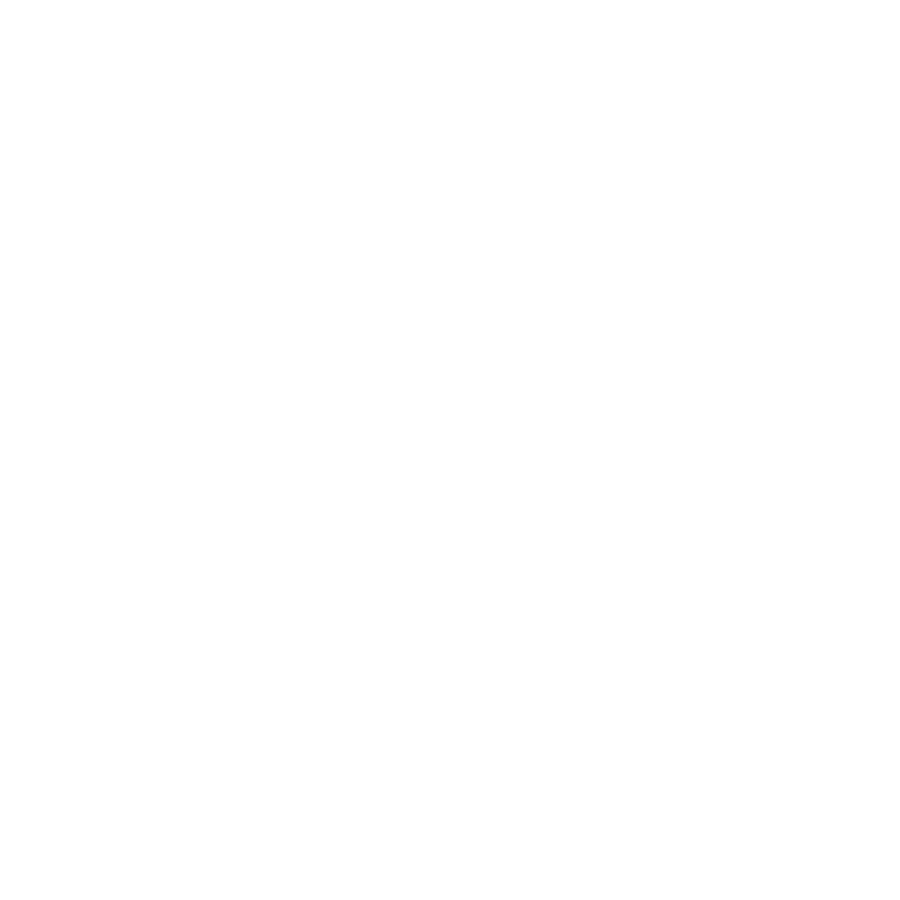

In [49]:
cat_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['val_loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cat_acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Categorical Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Report

In [50]:
y_pred_loss = model_loss.predict(test_set)
y_pred_acc = model_acc.predict(test_set)

In [51]:
X_test = np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y_test = np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print("Test - Images Shape: ", X_test.shape, '\n')
print("Test - Labels Shape: ", y_test.shape)

Test - Images Shape:  (1002, 224, 224, 3) 

Test - Labels Shape:  (1002, 7)


In [52]:

print("Min-Loss CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_loss.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
print(report)

Min-Loss CNN: 

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.04      0.04      0.04        51
         bkl       0.16      0.18      0.17       110
          df       0.00      0.00      0.00        12
         mel       0.20      0.01      0.02       111
          nv       0.68      0.80      0.73       671
        vasc       0.00      0.00      0.00        14

    accuracy                           0.56      1002
   macro avg       0.15      0.15      0.14      1002
weighted avg       0.50      0.56      0.51      1002



In [53]:
from sklearn.metrics import classification_report
print("Max-Acc CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_acc.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
print(report)

Max-Acc CNN: 

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.00      0.00      0.00        51
         bkl       0.15      0.04      0.06       110
          df       0.00      0.00      0.00        12
         mel       0.08      0.07      0.08       111
          nv       0.68      0.87      0.76       671
        vasc       0.00      0.00      0.00        14

    accuracy                           0.59      1002
   macro avg       0.13      0.14      0.13      1002
weighted avg       0.48      0.59      0.53      1002



C:\Users\suraj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
confusion_mtx = confusion_matrix(y_test.argmax(axis=1), y_pred_loss.argmax(axis=1))
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
confusion_mtx

array([[  0,   0,   4,   0,   0,  29,   0],
       [  3,   2,  10,   0,   1,  34,   1],
       [  2,   8,  20,   0,   1,  79,   0],
       [  0,   0,   0,   0,   0,  12,   0],
       [  1,   6,  14,   0,   1,  88,   1],
       [ 14,  38,  75,   1,   2, 536,   5],
       [  0,   0,   1,   0,   0,  13,   0]], dtype=int64)

**Over fitting Again, No improvement form previous experiments** 

# Exploring Patient Metadata   

In [62]:
df = pd.read_csv('dataverse_files/HAM10000_metadata.csv')
df['sum'] = pd.Series(np.ones(shape=(len(df))))
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,sum
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,1.0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,1.0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,1.0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,1.0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,1.0


In [63]:
a = df.groupby(['sex', 'dx'])['sum'].sum()
a = pd.DataFrame(a)
a.reset_index(inplace=True)
a

,sex,dx,sum
0,female,akiec,106.0
1,female,bcc,197.0
2,female,bkl,463.0
3,female,df,52.0
4,female,mel,424.0
5,female,nv,3237.0
6,female,vasc,73.0
7,male,akiec,221.0
8,male,bcc,317.0
9,male,bkl,626.0


In [64]:
fig = px.scatter_matrix(df, dimensions=['age', 'sex', 'localization'], color='dx')
fig.show()

### Age and sex

In [65]:
df['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [66]:
df['male_age'] = df.apply(lambda x: x['age'] if x['sex']=='male' else None, axis=1)
df['female_age'] = df.apply(lambda x: x['age'] if x['sex']=='female' else None, axis=1)
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,sum,male_age,female_age
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,1.0,80.0,NaN
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,1.0,80.0,NaN
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,1.0,80.0,NaN
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,1.0,80.0,NaN
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,1.0,75.0,NaN
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,1.0,40.0,NaN
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,1.0,40.0,NaN
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,1.0,40.0,NaN
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,1.0,80.0,NaN


### Localization

In [68]:
a = df.groupby(['localization', 'dx'])['sum'].sum().to_frame()

In [69]:
a.reset_index(inplace=True)
a

,localization,dx,sum
0,abdomen,akiec,5.0
1,abdomen,bcc,18.0
2,abdomen,bkl,42.0
3,abdomen,df,4.0
4,abdomen,mel,66.0
...,...,...,...
76,upper extremity,bkl,104.0
77,upper extremity,df,24.0
78,upper extremity,mel,213.0
79,upper extremity,nv,655.0


In [70]:
l=list()
for i in a.dx.unique():
    fig = px.bar(a[a['dx']==i], x='localization', y='sum', title=i)
    l.append(fig)
for i in range(len(l)):
    l[i].show()

# Using Patient Metadata for Classification 

### Extracting P(Class / Image Tensors) 

In [72]:
model = load_model('./best_model_acc_lra.hdf5')

In [73]:
def extract_img_array(id):
    s='dataverse_files/HAM10000_images/' + id + '.jpg'
    img = load_img(s, target_size=(224,224))
    arr = img_to_array(img)
    arr = np.divide(arr, 255)
    return arr

In [74]:
df = pd.read_csv('dataverse_files/HAM10000_metadata.csv')
df['images'] = df.image_id.swifter.set_npartitions(8).apply(lambda x: extract_img_array(x))

KeyboardInterrupt: 

In [ ]:
df.head()

In [ ]:
X_tensor = tf.data.Dataset.from_tensor_slices(df['images'].values.tolist())
X_tensor = X_tensor.batch(1)

In [90]:
pred = model.predict(X_tensor)

**Save the `pred` ndarray for later use**

In [91]:
np.save('dataverse_files/img_pred.npy', pred)

In [92]:
pred = np.load('dataverse_files/img_pred.npy')

In [93]:
X = pd.concat([pd.DataFrame(pred), df[['age', 'sex', 'localization']]], axis=1)
X = pd.get_dummies(X, columns = ['localization', 'sex'], drop_first=True)
X.head()

,0,1,2,3,4,5,6,age,localization_acral,localization_back,...,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity,sex_male,sex_unknown
0,0.007035,0.001547,0.650492,1.129137e-04,0.296944,0.043868,5.939582e-07,80.0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.000603,0.000012,0.990905,3.910033e-07,0.007074,0.001406,5.553173e-12,80.0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0.324047,0.047639,0.579520,4.932756e-04,0.040630,0.007670,2.061075e-06,80.0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0.015402,0.004745,0.962911,5.791981e-05,0.010224,0.006660,1.287858e-08,80.0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.002551,0.000010,0.992107,5.457800e-07,0.003411,0.001921,3.968451e-12,75.0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [102]:
y = df.replace({'dx' : { 'bcc' : 0, 'bkl' : 1, 'df' : 2, 'mel' : 3, 'nv' : 4, 'vasc': 5, 'akiec': 6}})['dx']
y = pd.get_dummies(y)
y

,0,1,2,3,4,5,6
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
10010,0,0,0,0,0,0,1
10011,0,0,0,0,0,0,1
10012,0,0,0,0,0,0,1
10013,0,0,0,0,0,0,1


In [127]:

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=0,
    stratify=y
)

In [128]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=0,
    stratify=y_train
)

In [129]:
print(X_train.shape)
print(y_train.shape)

(8111, 24)
(8111, 7)


In [130]:
#create a neural network using tensorflow
input_layer = Input(shape=(X_train.shape[1],))
dense_layer_1 = Dense(500,activation='relu')(input_layer)
dense_layer_2 = Dense(300,activation='relu')(dense_layer_1)
dense_layer_3 = Dense(200,activation='relu')(dense_layer_2)
dense_layer_4 = Dense(100, activation = 'relu')(dense_layer_3)
output = Dense(y_train.shape[1],activation='softmax')(dense_layer_4)

model = tf.keras.models.Model(inputs = input_layer, outputs = output)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
dense_11 (Dense)             (None, 500)               12500     
_________________________________________________________________
dense_12 (Dense)             (None, 300)               150300    
_________________________________________________________________
dense_13 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_15 (Dense)             (None, 7)                 707       
Total params: 243,807
Trainable params: 243,807
Non-trainable params: 0
_____________________________________________________

In [131]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [132]:
#train the model
history = model.fit(X_train, y_train, batch_size = 32, epochs = 50, verbose = 1, validation_data = (X_valid, y_valid))

Epoch 1/50
254/254 [==============================] - 3s 8ms/step - loss: 1.4222 - acc: 0.6548 - val_loss: 1.1348 - val_acc: 0.6696
Epoch 2/50
254/254 [==============================] - 1s 6ms/step - loss: 1.1288 - acc: 0.6707 - val_loss: 1.1325 - val_acc: 0.6696
Epoch 3/50
254/254 [==============================] - 2s 6ms/step - loss: 1.1341 - acc: 0.6729 - val_loss: 1.1379 - val_acc: 0.6696
Epoch 4/50
254/254 [==============================] - 2s 7ms/step - loss: 1.1559 - acc: 0.6605 - val_loss: 1.1326 - val_acc: 0.6696
Epoch 5/50
254/254 [==============================] - 2s 6ms/step - loss: 1.1375 - acc: 0.6680 - val_loss: 1.1318 - val_acc: 0.6696
Epoch 6/50
254/254 [==============================] - 1s 6ms/step - loss: 1.1340 - acc: 0.6707 - val_loss: 1.1327 - val_acc: 0.6696
Epoch 7/50
254/254 [==============================] - 1s 6ms/step - loss: 1.1206 - acc: 0.6762 - val_loss: 1.1356 - val_acc: 0.6696
Epoch 8/50
254/254 [==============================] - 1s 4ms/step - loss: 1.

In [133]:
#evaluation of the model
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

32/32 [==============================] - 0s 2ms/step - loss: 1.1319 - acc: 0.6697
Test Score: 1.1318572759628296
Test Accuracy: 0.6696606874465942


In [134]:
type(y_test)

pandas.core.frame.DataFrame

In [125]:
#converstion of training and testing data to create confusion matrix and get the accuracy score
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

y_pred = y_pred.argmax(axis = 1)
y_test = y_test.argmax(axis = 0)
y_pred_train = y_pred_train.argmax(axis = 1)


**Using the Prob values of each image belonging to every class of skin cancer lesion and the age, sex, localization data, we train a LGBM Classifier with the target as the Class of Skin Cancer Lesion. Its better to use a tree based classifier here due to the availability of Categorical Vars**

In [140]:
y = df.replace({'dx' : { 'bcc' : 0, 'bkl' : 1, 'df' : 2, 'mel' : 3, 'nv' : 4, 'vasc': 5, 'akiec': 6}})['dx']
y

0        1
1        1
2        1
3        1
4        1
        ..
10010    6
10011    6
10012    6
10013    6
10014    3
Name: dx, Length: 10015, dtype: int64

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420, stratify=y)

In [142]:
print('Train:\n', y_train.value_counts(), '\n')
print('Test:\n', y_test.value_counts())

Train:
 4    5364
3     890
1     879
0     411
6     262
5     114
2      92
Name: dx, dtype: int64 

Test:
 4    1341
3     223
1     220
0     103
6      65
5      28
2      23
Name: dx, dtype: int64


## Training Using LGBM

In [143]:
params = {
    "objective": "multiclass",
    "num_class": 7,
    "num_leaves": 15,
    "max_depth": 3,
    "learning_rate": 0.1,
    #"bagging_fraction": 1,
    #"feature_fraction": 0.7,
    #"bagging_freq": 20,
    #"bagging_seed": 2018,
    "verbosity": -1,
    "num_threads":8
}
train_lgbm = lgb.Dataset(X_train, y_train)
test_lgbm = lgb.Dataset(X_test, y_test)

In [144]:
def train_lgb(train_lgbm, test_lgbm, params):
    evals_result = {}
    lgbmodel = lgb.train(params,
                         train_lgbm,
                         num_boost_round=500,
                         valid_sets=[train_lgbm, test_lgbm],
                         early_stopping_rounds=20,
                         verbose_eval=50,
                         evals_result=evals_result)
    lgb.plot_metric(evals_result,metric = 'multi_logloss')
    return lgbmodel

C:\Users\suraj\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\Users\suraj\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

C:\Users\suraj\anaconda3\lib\site-packages\lightgbm\engine.py:260: UserWarning:

'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.



Training until validation scores don't improve for 20 rounds
[50]	training's multi_logloss: 0.213006	valid_1's multi_logloss: 0.278909
Early stopping, best iteration is:
[59]	training's multi_logloss: 0.205171	valid_1's multi_logloss: 0.277186


<IPython.core.display.Javascript object>


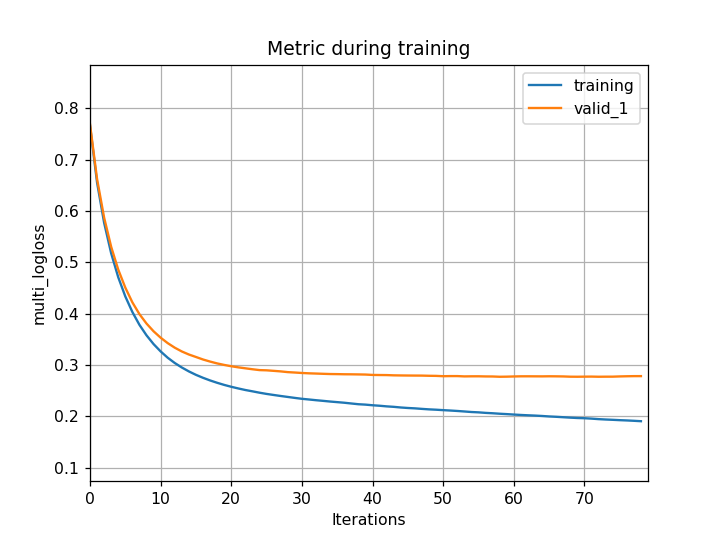

In [145]:
lgbmodel = train_lgb(train_lgbm, test_lgbm, params)

## Evaluation

In [151]:
preds = lgbmodel.predict(X_train)
Y_pred = np.argmax(np.round(preds),axis = 1)
print(Y_pred.shape, y_train.shape)

from sklearn.metrics import classification_report,accuracy_score,f1_score
target_names = ["Class {}".format(i) for i in range(7)]
print("Training Scores:\n", classification_report(y_train, Y_pred, target_names=target_names))

(8012,) (8012,)
Training Scores:
               precision    recall  f1-score   support

     Class 0       0.60      0.93      0.73       411
     Class 1       0.89      0.80      0.84       879
     Class 2       0.99      0.84      0.91        92
     Class 3       0.83      0.69      0.76       890
     Class 4       0.96      0.96      0.96      5364
     Class 5       1.00      0.99      1.00       114
     Class 6       0.87      0.76      0.81       262

    accuracy                           0.91      8012
   macro avg       0.88      0.85      0.86      8012
weighted avg       0.91      0.91      0.91      8012



,Recall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,90.72641,90.72641,1.55,9.27,97.35,90.72641
0,93.00000,60.00000,3.00,7.00,96.00,73.00000
1,80.00000,89.00000,1.00,20.00,97.00,84.00000
2,84.00000,99.00000,0.00,16.00,100.00,91.00000
3,69.00000,83.00000,2.00,31.00,95.00,76.00000
4,96.00000,96.00000,9.00,4.00,95.00,96.00000
5,99.00000,100.00000,0.00,1.00,100.00,100.00000
6,76.00000,87.00000,0.00,24.00,99.00,81.00000


### Evaluation on testing

In [152]:
preds = lgbmodel.predict(X_test)
Y_pred = np.argmax(np.round(preds),axis = 1)
print(Y_pred.shape, y_test.shape)

from sklearn.metrics import classification_report,accuracy_score,f1_score
target_names = ["Class {}".format(i) for i in range(7)]
print("Testing Scores:\n", classification_report(y_test, Y_pred, target_names=target_names))

(2003,) (2003,)
Testing Scores:
               precision    recall  f1-score   support

     Class 0       0.58      0.91      0.71       103
     Class 1       0.84      0.75      0.79       220
     Class 2       0.91      0.91      0.91        23
     Class 3       0.77      0.68      0.72       223
     Class 4       0.96      0.95      0.95      1341
     Class 5       0.96      0.96      0.96        28
     Class 6       0.87      0.72      0.79        65

    accuracy                           0.89      2003
   macro avg       0.84      0.84      0.83      2003
weighted avg       0.90      0.89      0.89      2003



,Recall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,89.166251,89.166251,1.81,10.83,96.9,89.166251
0,91.000000,58.000000,4.00,9.00,96.0,71.000000
1,75.000000,84.000000,2.00,25.00,96.0,79.000000
2,91.000000,91.000000,0.00,9.00,100.0,91.000000
3,68.000000,77.000000,3.00,32.00,94.0,72.000000
4,95.000000,96.000000,9.00,5.00,94.0,95.000000
5,96.000000,96.000000,0.00,4.00,100.0,96.000000
6,72.000000,87.000000,0.00,28.00,99.0,79.000000


In [153]:
confusion_mtx = confusion_matrix(y_test, Y_pred)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
confusion_mtx

array([[  94,    3,    2,    1,    2,    0,    1],
       [  19,  165,    0,   14,   17,    0,    5],
       [   2,    0,   21,    0,    0,    0,    0],
       [  19,   11,    0,  152,   39,    1,    1],
       [  20,   11,    0,   30, 1280,    0,    0],
       [   1,    0,    0,    0,    0,   27,    0],
       [   8,    7,    0,    1,    2,    0,   47]], dtype=int64)

In [156]:
print(classification_report(y_test, Y_pred,target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.58      0.91      0.71       103
     Class 1       0.84      0.75      0.79       220
     Class 2       0.91      0.91      0.91        23
     Class 3       0.77      0.68      0.72       223
     Class 4       0.96      0.95      0.95      1341
     Class 5       0.96      0.96      0.96        28
     Class 6       0.87      0.72      0.79        65

    accuracy                           0.89      2003
   macro avg       0.84      0.84      0.83      2003
weighted avg       0.90      0.89      0.89      2003

